## Kaggle用データのインポート

In [1]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"droeloe","key":"c330037c8e955090c87e6872ec333b32"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip -o {COMPETITION}
!rm {COMPETITION}.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 27.1MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## ライブラリのインポート

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from numpy import mean, std

import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from scipy.special import boxcox1p
from IPython.core.display import HTML
from scipy.stats import norm, skew #for some statistics
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from copy import deepcopy
from scipy.stats import boxcox, yeojohnson

### User modules

In [4]:
# 並び替え検定用の関数
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [5]:
# permutation test
def permutation_test(data, var, target):

  vA = data[var].dropna().unique()[0]
  vB = data[var].dropna().unique()[1]
  mean_a = data[data[var] == vA][target].mean()
  mean_b = data[data[var] == vB][target].mean()
  print(f"{target} mean value with {var}={vA}: {mean_a}")
  print(f"{target} mean value with {var}={vB}: {mean_b}")
  print(f"{target} observed difference between ({var}={vA}) and ({var}={vB}): {mean_b - mean_a}")
  nA = data[data[var] == vA].shape[0]
  nB = data[data[var] == vB].shape[0]

  random.seed(1)
  perm_diffs = pd.Series([perm_fun(data[target], nA, nB) for _ in range(1000)])
  perm_diffs = perm_diffs.dropna()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.hist(perm_diffs, bins=11, rwidth=0.9)
  ax.axvline(x = mean_b - mean_a, color='black', lw=2)
  ax.text(mean_b - mean_a, 10, 'Observed\ndifference', bbox={'facecolor':'white'})
  ax.set_xlabel(f'{var} differences')
  ax.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

  perm_diffs = np.array(perm_diffs)
  print('p-value: ', (np.mean(perm_diffs > mean_b - mean_a)))

In [6]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [7]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [8]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [9]:
# ANOVA using permutation test
# Image size が ～～～ のエラーが出た場合は logx = True に設定する
def anova_perm(data, var, target, logx=False):

  # Creating crosstab
  crosstb = pd.crosstab(data[var], data[target])

  # Creating barplot
  # pl = crosstb.plot(kind="bar", stacked=True, rot=0)

  for col in data[var].unique():
      try:
          true_ratio = len(data[(data[var]==col)&(data[target]==True)]) / len(data[data[var]==col])
      except:
          break
      print(col, true_ratio)

  observed_variance = data.groupby(var).mean().var()[target] # グループごとの平均値を求め、その平均値の分散を計算している
  print('Observed means:', data.groupby(var).mean()[target].values.ravel()) # ravel: 横方向の1次元のベクトルを返す
  print('Variance:', observed_variance)
  # Permutation test example with stickiness
  def perm_test(data):
      data = data.copy()
      data[target] = np.random.permutation(data[target].values)
      return data.groupby(var).mean().var()[target]

  random.seed(1)
  perm_variance = [perm_test(data) for _ in range(3000)]
  print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

  if logx == True:
    # 横長のグラフになってしまうので自然対数を取った（通常は下記2行は不要）
    observed_variance_log = np.log(observed_variance)
    perm_variance_log = np.log(perm_variance)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance_log, bins=11, rwidth=0.9)

    # 横長のグラフになってしまうので自然対数を取った（通常はxにobserved_varianceを指定）
    ax.axvline(x = observed_variance_log, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance, bins=11, rwidth=0.9)

    ax.axvline(x = observed_variance, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [10]:
# column_transformer 利用後のカラム名を取得する関数
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'): ## hasattrは引数がメソッドやプロパティであった場合にTrueを返す
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names
# get_feature_names(preprocessor)

In [11]:
def scatter_hist(data, xlabel, ylabel):
  x = data[xlabel]
  y = data[ylabel]

  fig = plt.figure(figsize=(8,8))
  gs = gridspec.GridSpec(3, 3)
  ax_main = plt.subplot(gs[1:3, :2])
  ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
  ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

  ax_main.scatter(x,y,marker='.')
  ax_main.set(xlabel=xlabel, ylabel=ylabel)

  ax_xDist.hist(x,bins=100,align='mid')
  ax_xDist.set(ylabel='count')
  ax_xCumDist = ax_xDist.twinx()
  ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
  ax_xCumDist.tick_params('y', colors='r')
  ax_xCumDist.set_ylabel('cumulative',color='r')

  ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
  ax_yDist.set(xlabel='count')
  ax_yCumDist = ax_yDist.twiny()
  ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
  ax_yCumDist.tick_params('x', colors='r')
  ax_yCumDist.set_xlabel('cumulative',color='r')

  plt.show()

In [12]:
def get_num_cat_column_names(df, target):
  feature_cols = df.columns.drop(target)
  categorical_cols = []
  numerical_cols = []
  for i in feature_cols:
      if df[i].dtype=='object':
          categorical_cols.append(i)
      else:
          numerical_cols.append(i)

  return categorical_cols, numerical_cols

In [13]:
def get_skewed_column_names(df, numerical_cols, threshold=0.75):
  skewed_feats = df[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  skewness = pd.DataFrame({'Skew' :skewed_feats})
  skewness = skewness[skewness.abs() > threshold]
  skewness.dropna(inplace=True)
  skewed_features = skewness.index.copy()

  new_numerical_cols = numerical_cols.copy()
  for col in skewed_features:
    new_numerical_cols.remove(col)

  return skewed_features, new_numerical_cols

In [14]:
def split_data(data, target):
  train_len = data.shape[0]-data[target].isna().sum()
  train_X = data.iloc[:train_len][data.columns.drop(target)]
  train_y = pd.DataFrame(data.iloc[:train_len][target], columns=[target])
  test_X = data.iloc[train_len:][data.columns.drop(target)]

  return train_X, train_y, test_X

In [15]:
#Validation function
n_folds = 5

def get_rmse_CV(model, train_X, train_y):
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = cross_validate(model, train_X, train_y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
    rmse = np.sqrt(-scores["test_score"])

    return(rmse)

## 外れ値を削除する Transformer

In [16]:
class CleanOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0, strategy="mean"):
        self.contamination = contamination
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.contamination==0: return self
        self.lof = LocalOutlierFactor(contamination=self.contamination, novelty=True)
        self.lof.fit(X)
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        if self.contamination==0: return X
        idx_outlier = self.lof.predict(X)==-1
        X[idx_outlier, :] = np.nan # set NaN to outlier value

        simple_imputer = SimpleImputer(strategy=self.strategy)
        X = simple_imputer.fit_transform(X) # fill outlier value usin simple_imputer

        return X

In [17]:
class SigmaOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, sigma=3):
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        X = pd.DataFrame(X)
        for col in X.columns:
          m = np.mean(X[col])
          sd = np.std(X[col])
          X[X[col]>(sd*self.sigma+m)] = m + sd * self.sigma
          X[X[col]<(sd*self.sigma*-1+m)] = m - sd * self.sigma

        return X.to_numpy()

## データのダウンロード

In [18]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")
target = "SalePrice"

all_data = pd.concat([train, test], axis=0, ignore_index=True)

In [19]:
print(f'\033[32mtrain size : {train.shape[0]} x {train.shape[1]}')
print(f'\033[32mtest size : {test.shape[0]} x {test.shape[1]}')
print(f'\033[32mtotal size : {all_data.shape[0]} x {all_data.shape[1]}')

train size : 1460 x 81
test size : 1459 x 80
total size : 2919 x 81


## カテゴリ変数の定義

### 量的変数、カテゴリ変数の定義
自動で数的変数、カテゴリ変数、名義尺度 等を判別する

In [20]:
categorical_cols, numerical_cols = get_num_cat_column_names(all_data, target)
print('Number of categorical features:', str(len(categorical_cols)))
print('Number of numerical features:', str(len(numerical_cols)))

Number of categorical features: 43
Number of numerical features: 37


# 外れ値の削除

In [21]:
import pandas as pd

class OutlierHandler:

    def __init__(self):
        # 外れ値のインデックスを格納する辞書
        self.outliers_indices_residuals_fixed = {}

    def get_outlier_lr(self, data, target, outlier_per_col):
      all_data_outlier = data.copy()
      # Dictionary to store the index numbers of outliers detected through residuals for each column
      self.outliers_indices_residuals_fixed = {}

      all_data_outlier[target] = np.log1p(all_data_outlier[target])

      # Loop through the top 10 correlated features and detect outliers using residuals
      for feature in numerical_cols:
          # Dropping NaN values for the specific feature and corresponding SalePrice
          if feature == target:
            break
          feature_data = all_data_outlier[[feature, target]].dropna(subset=[feature, target])

          # Preparing the feature and target data
          X = feature_data[[feature]]
          y = feature_data[target]

          # Creating a linear regression model
          model = LinearRegression()
          model.fit(X, y)

          # Predicting the SalePrice and calculating residuals
          predictions = model.predict(X)
          residuals = y - predictions

          # Finding the index numbers of top 5 largest absolute residuals
          outlier_indices_residuals = residuals.abs().nlargest(5).index.tolist()

          # Storing the index numbers in the dictionary
          self.outliers_indices_residuals_fixed[feature] = outlier_indices_residuals

      # Displaying the index numbers of outliers detected through residuals for each feature
      return self.outliers_indices_residuals_fixed

    def remove_outliers(self, data):
        outliers = []
        for li in self.outliers_indices_residuals_fixed.values():
          outliers.extend(li)
        outliers = list(set(outliers))

        for outlier in outliers:
          if outlier < len(target):
            data = data.drop(outlier)
        return data

    def plot_outliers(self, numerical_cols, all_data_outlier, target):
        fig, axes = plt.subplots(math.ceil(len(numerical_cols)/2), 2, figsize=(10, 15))
        axes = axes.flatten()

        for i, (feature, outlier_indices) in enumerate(self.outliers_indices_residuals_fixed.items()):
            # Preparing the feature and target data without NaN values
            feature_data = all_data_outlier[[feature, target]].dropna(subset=[feature, target])
            X = feature_data[[feature]]
            y = feature_data[target]

            # Creating a linear regression model and fitting
            model = LinearRegression()
            model.fit(X, y)

            # Predicting the SalePrice for the regression line
            predictions = model.predict(X)

            # Plotting all data points
            axes[i].scatter(X, y, label='Data', alpha=0.5)

            # Plotting the regression line
            axes[i].plot(X, predictions, color='green', label='Regression Line')

            # Highlighting the outliers and annotating with index numbers
            for idx in outlier_indices:
                axes[i].scatter(X.loc[idx], y.loc[idx], color='red', label='Outliers' if idx == outlier_indices[0] else "")
                axes[i].text(X.loc[idx], y.loc[idx], str(idx), fontsize=9, color='blue')

            axes[i].set_title(f'Scatter Plot of {feature} vs {target} with Regression Line')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel(target)
            axes[i].legend()

        plt.tight_layout()
        plt.show()

In [22]:
categorical_cols, numerical_cols = get_num_cat_column_names(all_data, target)
handler = OutlierHandler()
outliers_indices_residuals_fixed = handler.get_outlier_lr(all_data.copy(), target, outlier_per_col=5)
all_data_outlier = handler.remove_outliers(all_data.copy())
print(all_data_outlier.shape)
# handler.plot_outliers(numerical_cols, all_data_outlier, target)

(2919, 81)


## 非線形変換を行う前の精度を確認

In [23]:
def feature_engineering(data):
  # add new feature
  data["SalePrice"] = np.log1p(data["SalePrice"])
  data["YearSinceRemodel"] = data["YrSold"] - data["YearBuilt"] # ここで新しい特徴量を追加する
  data['BsmtFinType1_Unf'] = 1*(data['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
  data['HasWoodDeck'] = (data['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
  data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond'] # ここで新しい特徴量を追加する
  data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] # ここで新しい特徴量を追加する
  data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  data['YrBltAndRemod'] = data['YearBuilt'] + data['YearRemodAdd']
  data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'])
  data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
  data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

  # delete features
  data = data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
  return data

In [24]:
categorical_cols, numerical_cols = get_num_cat_column_names(all_data, target)
handler = OutlierHandler()
outliers_indices_residuals_fixed = handler.get_outlier_lr(all_data.copy(), target, outlier_per_col=5)
all_data_outlier = handler.remove_outliers(all_data.copy())

# 特徴量エンジニアリング
all_data_inference =feature_engineering(all_data_outlier.copy())

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_inference, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_inference, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median"))])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_lgbm = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor(objective='regression', num_leaves=4,learning_rate=0.01, n_estimators=6000,
                          max_bin=200, bagging_fraction=0.75,bagging_freq=5, bagging_seed=7,
                          feature_fraction=0.2,feature_fraction_seed=7,verbose=-1))
    # ('model', lgb.LGBMRegressor())
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_inference, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline_lgbm, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LGBM score: 0.1277 (0.0171)



PublicはScore: 0.12446

In [25]:
pipeline_lgbm.fit(train_X, train_y)
preds = np.expm1(pipeline_lgbm.predict(test_X))
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': preds})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

,Id,SalePrice
0,1461,122013.995706
1,1462,163192.193810
2,1463,178894.718928
3,1464,192796.010305
4,1465,185079.059167
...,...,...
1454,2915,80962.834253
1455,2916,80675.360889
1456,2917,166818.597432
1457,2918,120881.554826


# 非線形変換

In [26]:
class nonlinear_transform():
    def __init__(self):
        # 外れ値のインデックスを格納する辞書
        self.best_transforms = {}
        self.op_cols = []

    def get_best_transforms(self, data, numerical_cols, exception_cols):
        self.op_cols = [item for item in numerical_cols if item not in exception_cols]
        for feature in self.op_cols:
            feature_skewness = {}

            # Original skewness
            feature_skewness['Original'] = skew(data[feature].dropna())

            # log1p transformation skewness
            feature_skewness['log1p'] = skew(np.log1p(data[feature].dropna()))

            # Box-Cox transformation skewness
            # Adding a small constant to ensure positive values
            bc_transformed, _ = boxcox(data[feature].dropna() + 1e-6)
            feature_skewness['Box-Cox'] = skew(bc_transformed)

            # Yeo-Johnson transformation skewness
            yj_transformed, _ = yeojohnson(data[feature].dropna())
            feature_skewness['Yeo-Johnson'] = skew(yj_transformed)

            # Determine the best transformation
            best_transformation = min(feature_skewness, key=lambda k: abs(feature_skewness[k]))

            # Store results in best_transforms dictionary
            self.best_transforms[feature] = best_transformation

    def apply_best_transform(self, feature, data, transformation):
        if transformation == "log1p":
            data[feature] = np.log1p(data[feature].dropna())
            return np.log1p(data[feature].dropna())
        elif transformation == "Box-Cox":
            data.loc[~data[feature].isna(), feature] = boxcox(data[feature].dropna() + 1e-6)[0]
            return data[feature]
        elif transformation == "Yeo-Johnson":
            data.loc[~data[feature].isna(), feature] = yeojohnson(data[feature].dropna())[0]
            return data[feature]
        else:
            return data[feature].dropna()

    def apply_best_transform_all(self, data, numerical_cols, plot=False):
        # Plot the distributions before and after best transformation
        if plot == True:
          fig, axarr = plt.subplots(len(self.op_cols), 2, figsize=(15, 100))

        for i, feature in enumerate(self.op_cols):
            # Original skewness
            original_skew = skew(data[feature].dropna())

            # Transformed data and skewness
            transformed_data = self.apply_best_transform(feature, data, self.best_transforms[feature])
            transformed_skew = skew(transformed_data.dropna())

            if plot==True:
              # Original data distribution
              axarr[i][0].hist(all_data[feature].dropna(), bins=50, color='blue', alpha=0.5, label='Original')
              axarr[i][0].set_title(f"{feature} - Original")
              axarr[i][0].set_xlabel(feature)
              axarr[i][0].set_ylabel("Frequency")
              axarr[i][0].legend()
              axarr[i][0].text(0.6, 0.65, f"Skewness: {original_skew:.2f}", transform=axarr[i][0].transAxes)

              # Transformed data distribution
              axarr[i][1].hist(transformed_data, bins=50, color='green', alpha=0.5, label=f'Transformed ({self.best_transforms[feature]})')
              axarr[i][1].set_title(f"{feature} - Transformed ({self.best_transforms[feature]})")
              axarr[i][1].set_xlabel(feature)
              axarr[i][1].set_ylabel("Frequency")
              axarr[i][1].legend()
              axarr[i][1].text(0.6, 0.65, f"Skewness: {transformed_skew:.2f}", transform=axarr[i][1].transAxes)
        if plot == True:
          plt.tight_layout()
          plt.show()
        return data

In [27]:
categorical_cols, numerical_cols = get_num_cat_column_names(all_data, target)
handler = OutlierHandler()
outliers_indices_residuals_fixed = handler.get_outlier_lr(all_data.copy(), target, outlier_per_col=5)
all_data_outlier = handler.remove_outliers(all_data.copy())

exception_cols = ["Id", "BsmtFinSF2", "2ndFlrSF", "LowQualFinSF", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "YrSold", "SalePrice"]
transform = nonlinear_transform()
transform.get_best_transforms(all_data_outlier.copy(), numerical_cols, exception_cols)
transformed_data = transform.apply_best_transform_all(all_data_outlier.copy(), numerical_cols, plot=False)

# スコアの確認

In [28]:
def feature_engineering(data):
  data["SalePrice"] = np.log1p(data["SalePrice"])
  # add new feature
  data["YearSinceRemodel"] = data["YrSold"] - data["YearBuilt"] # ここで新しい特徴量を追加する
  data['BsmtFinType1_Unf'] = 1*(data['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
  data['HasWoodDeck'] = (data['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
  data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond'] # ここで新しい特徴量を追加する
  data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] # ここで新しい特徴量を追加する
  data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  data['YrBltAndRemod'] = data['YearBuilt'] + data['YearRemodAdd']
  data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'])
  data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
  data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

  # delete features
  data = data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
  return data

In [33]:
categorical_cols, numerical_cols = get_num_cat_column_names(all_data, target)
handler = OutlierHandler()
outliers_indices_residuals_fixed = handler.get_outlier_lr(all_data.copy(), target, outlier_per_col=5)
all_data_outlier = handler.remove_outliers(all_data.copy())

exception_cols = ["Id", "BsmtFinSF2", "2ndFlrSF", "LowQualFinSF", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "YrSold", "SalePrice"]
transform = nonlinear_transform()
transform.get_best_transforms(all_data_outlier.copy(), numerical_cols, exception_cols)
all_data_nonlinear = transform.apply_best_transform_all(all_data_outlier.copy(), numerical_cols, plot=False)

# all_data_inference = all_data_nonlinear.copy()

# 特徴量エンジニアリング
all_data_inference =feature_engineering(all_data_nonlinear.copy())

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_inference, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_inference, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median"))])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_lgbm = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor(objective='regression', num_leaves=4,learning_rate=0.01, n_estimators=6000,
                          max_bin=200, bagging_fraction=0.75,bagging_freq=5, bagging_seed=7,
                          feature_fraction=0.2,feature_fraction_seed=7,verbose=-1))
    # ('model', lgb.LGBMRegressor())
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_inference, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline_lgbm, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LGBM score: 0.1265 (0.0180)



Score: 0.12444


In [34]:
pipeline_lgbm.fit(train_X, train_y)
preds = np.expm1(pipeline_lgbm.predict(test_X))
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': preds})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

,Id,SalePrice
0,1461,122295.526984
1,1462,156228.377860
2,1463,181150.270534
3,1464,189789.891472
4,1465,184076.932288
...,...,...
1454,2915,82083.290541
1455,2916,80214.980123
1456,2917,159486.597570
1457,2918,117697.624310


# 推論

## LGBM

## Ridge

0.13972551551810453

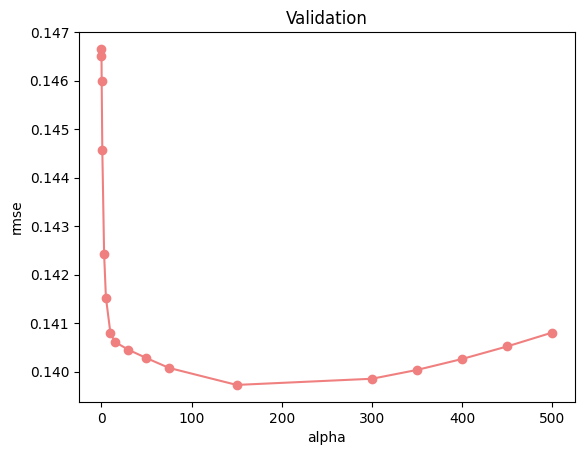

In [35]:
from sklearn.linear_model import Ridge


all_data_inference = all_data_nonlinear.copy()

# 特徴量エンジニアリング
all_data_inference =feature_engineering(all_data_inference)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_inference, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_inference, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
# categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_ridge = Pipeline([
    ('preprocessing', preprocessor),
    ('model',  Ridge(alpha=1.0))
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_inference, target)

# 作成したPipelineの精度を評価する
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 150, 300, 350, 400, 450, 500]
results = [get_rmse_CV(pipeline_ridge.set_params(model__alpha = alpha), train_X, train_y).mean()
            for alpha in alphas]
results = pd.Series(results, index = alphas)
results.plot(title = "Validation", marker="o")
plt.xlabel("alpha")
plt.ylabel("rmse")
results.min()

0.13059447409477792

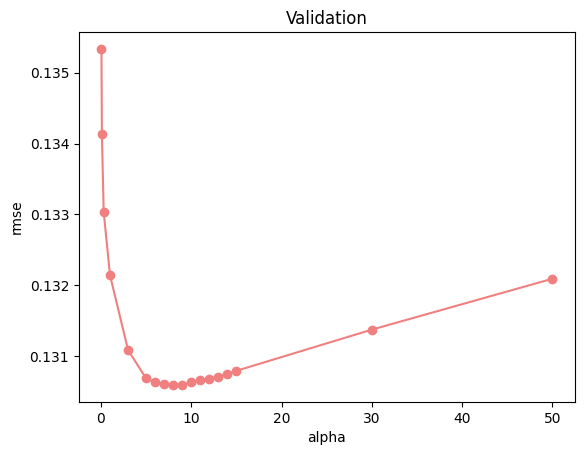

In [36]:
from sklearn.linear_model import Ridge

all_data_inference = all_data_nonlinear.copy()

# 特徴量エンジニアリング
all_data_inference =feature_engineering(all_data_inference)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_inference, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_inference, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
# categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_ridge = Pipeline([
    ('preprocessing', preprocessor),
    ('model',  Ridge(alpha=1.0))
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_inference, target)

# 作成したPipelineの精度を評価する
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 30, 50]
results = [get_rmse_CV(pipeline_ridge.set_params(model__alpha = alpha), train_X, train_y).mean()
            for alpha in alphas]
results = pd.Series(results, index = alphas)
results.plot(title = "Validation", marker="o")
plt.xlabel("alpha")
plt.ylabel("rmse")
results.min()

In [37]:
pipeline_ridge.fit(train_X, train_y)
preds = np.expm1(pipeline_ridge.predict(test_X))
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': preds.reshape(test["Id"].values.shape)})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

,Id,SalePrice
0,1461,114158.282144
1,1462,152177.784681
2,1463,178512.197895
3,1464,196594.309402
4,1465,190144.680478
...,...,...
1454,2915,85338.858711
1455,2916,81817.935140
1456,2917,161083.457225
1457,2918,115858.748587


## Lasso

0.13811348660709794

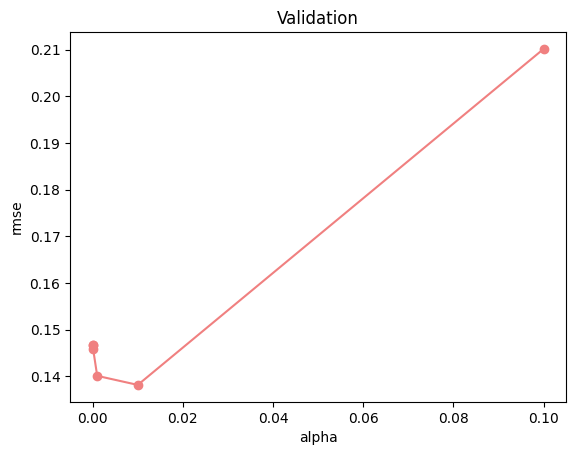

In [38]:
from sklearn.linear_model import Lasso

all_data_inference = all_data_nonlinear.copy()

# 特徴量エンジニアリング
all_data_inference =feature_engineering(all_data_inference)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_inference, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_inference, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
# categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_lasso = Pipeline([
    ('preprocessing', preprocessor),
    ('model',  Lasso(alpha=1.0))
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_inference, target)

# 作成したPipelineの精度を評価する
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = [get_rmse_CV(pipeline_lasso.set_params(model__alpha = alpha), train_X, train_y).mean()
            for alpha in alphas]
results = pd.Series(results, index = alphas)
results.plot(title = "Validation", marker="o")
plt.xlabel("alpha")
plt.ylabel("rmse")
results.min()

0.12994759087784874

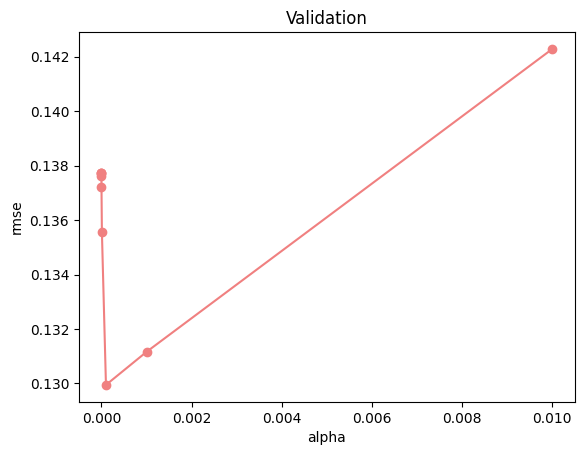

In [39]:
from sklearn.linear_model import Lasso

all_data_inference = all_data_nonlinear.copy()

# 特徴量エンジニアリング
all_data_inference =feature_engineering(all_data_inference)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_inference, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_inference, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
# categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_lasso = Pipeline([
    ('preprocessing', preprocessor),
    ('model',  Lasso(alpha=1.0))
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_inference, target)

# 作成したPipelineの精度を評価する
alphas = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = [get_rmse_CV(pipeline_lasso.set_params(model__alpha = alpha), train_X, train_y).mean()
            for alpha in alphas]
results = pd.Series(results, index = alphas)
results.plot(title = "Validation", marker="o")
plt.xlabel("alpha")
plt.ylabel("rmse")
results.min()

## ElasticNet

0.137353576159271

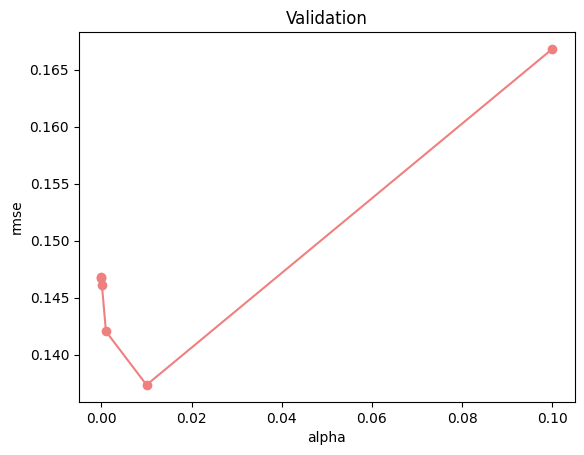

In [40]:
from sklearn.linear_model import ElasticNet

all_data_inference = all_data_nonlinear.copy()

# 特徴量エンジニアリング
all_data_inference =feature_engineering(all_data_inference)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_inference, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_inference, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
# categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_ElasticNet = Pipeline([
    ('preprocessing', preprocessor),
    ('model',  ElasticNet(alpha=1.0))
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_inference, target)

# 作成したPipelineの精度を評価する
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = [get_rmse_CV(pipeline_ElasticNet.set_params(model__alpha = alpha), train_X, train_y).mean()
            for alpha in alphas]
results = pd.Series(results, index = alphas)
results.plot(title = "Validation", marker="o")
plt.xlabel("alpha")
plt.ylabel("rmse")
results.min()

0.129352506880905

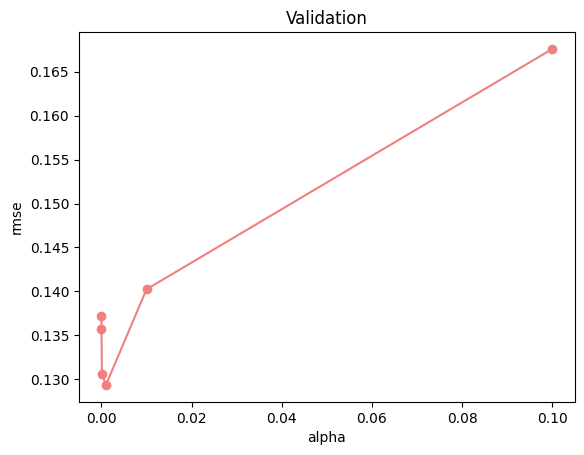

In [41]:
from sklearn.linear_model import ElasticNet

all_data_inference = all_data_nonlinear.copy()

# 特徴量エンジニアリング
all_data_inference =feature_engineering(all_data_inference)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_inference, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_inference, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
# categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_ElasticNet = Pipeline([
    ('preprocessing', preprocessor),
    ('model',  ElasticNet(alpha=1.0))
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_inference, target)

# 作成したPipelineの精度を評価する
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = [get_rmse_CV(pipeline_ElasticNet.set_params(model__alpha = alpha), train_X, train_y).mean()
            for alpha in alphas]
results = pd.Series(results, index = alphas)
results.plot(title = "Validation", marker="o")
plt.xlabel("alpha")
plt.ylabel("rmse")
results.min()

In [42]:
pipeline_ElasticNet.set_params(model__alpha = 1e-3)
pipeline_ElasticNet.fit(train_X, train_y)
preds = np.expm1(pipeline_ElasticNet.predict(test_X))
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': preds})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

,Id,SalePrice
0,1461,116609.621173
1,1462,152046.851503
2,1463,179444.142317
3,1464,195747.854605
4,1465,197167.549757
...,...,...
1454,2915,86653.599951
1455,2916,82755.047992
1456,2917,161679.718723
1457,2918,118338.377960


## やりたいこと
https://www.kaggle.com/code/angqx95/data-science-workflow-top-2-with-tuning#4.-Modeling

# メインから外れるコード